In [3]:
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [206]:
pickle_in = open('sentiment.pickle' , 'rb')
sentiment = pickle.load(pickle_in)

In [207]:
pickle_in = open('input_news.pickle' , 'rb')
x_in = pickle.load(pickle_in)

In [208]:
pickle_in = open('input_stocks.pickle' , 'rb')
x_in_stock = pickle.load(pickle_in)

In [221]:
token_news = pd.read_csv('final_dataset_007.csv')
t = Tokenizer()
t.fit_on_texts(token_news['headline_clean'])

In [210]:
stocks_pred = np.array(token_news['Open'])
stocks_pred = stocks_pred.reshape(-1,1)

In [211]:
stocks_pred.shape

(2624, 1)

In [212]:
news_seq = t.texts_to_sequences(token_news['headline_clean'])
news_seq = pad_sequences(news_seq , maxlen= 20 , padding= 'post' , truncating= 'post')

In [213]:
news_seq.shape

(2624, 20)

In [214]:
max_lenn = t.word_index
len(max_lenn)

18294

In [215]:
scaler = MinMaxScaler()
scaler_op = MinMaxScaler()
x_in_stock = scaler.fit_transform(x_in_stock)
stocks_pred = scaler_op.fit_transform(stocks_pred)

In [216]:
x_in_stock = x_in_stock.reshape(2624,40,1)

In [217]:
x_in = news_seq.reshape(2624,20,1)

In [154]:
from tensorflow.keras.layers import LSTM, Dense , Input , Dropout , Concatenate , Embedding
from tensorflow.keras.models import Model

In [228]:
inn_stock = Input(shape = (40,1))
inn_n = Input(shape = (20,1))

#For stocks input
lstm1 = LSTM(60, return_sequences=True)(inn_stock)
dropout1 = Dropout(0.4)(lstm1)

lstm3 = LSTM(50 , return_sequences = False )(dropout1)

dense1 = Dense(50, activation = 'tanh',kernel_regularizer=tf.keras.regularizers.l2(0.001))(lstm3)
dense2 = Dense(25, activation = 'tanh',kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense1)
dropout3 = Dropout(0.3)(dense2)
dense3 = Dense(20, activation = 'tanh')(dropout3)

#For news input

embb = Embedding(18294 , 50)(inn_n)
lstm_n = LSTM(50 , return_sequences = False)(inn_n)
dense_1_n  = Dense(40 , activation = 'relu' , kernel_regularizer = 'l1' )(lstm_n)
dropout_2_n = Dropout(0.1)(dense_1_n)
dense_2_n = Dense(20 , activation = 'relu')(dropout_2_n)
dense_f = Dense(30 , activation = 'relu' , kernel_regularizer = 'l1' )(dense_2_n)
#Concat both vectors
finn = Concatenate(axis=1)([dense3 , dense_f])
dense_f = Dense(10 , activation = 'relu' , kernel_regularizer = 'l1' )(finn)
op_dense = Dense(1)(dense_f)

model = Model(inputs = [inn_stock , inn_n ] , outputs = [op_dense])


In [229]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 40, 1)]      0                                            
__________________________________________________________________________________________________
lstm_54 (LSTM)                  (None, 40, 60)       14880       input_36[0][0]                   
__________________________________________________________________________________________________
dropout_42 (Dropout)            (None, 40, 60)       0           lstm_54[0][0]                    
__________________________________________________________________________________________________
input_37 (InputLayer)           [(None, 20, 1)]      0                                            
____________________________________________________________________________________________

In [230]:
tf.keras.utils.plot_model(model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [231]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0025) , loss = 'mean_squared_error')

In [232]:
#news data
x_train_n = x_in[:1900]
x_test_n =  x_in[1900:]
y_train = stocks_pred[:1900]
y_test = stocks_pred[1900:]

#Stocks Data

x_train_s = x_in_stock[:1900]
x_test_s = x_in_stock[1900:]

In [233]:
x_train_n.shape

(1900, 20, 1)

In [243]:
history = model.fit([x_train_s , x_train_n] , y_train , epochs = 10 , batch_size = 32 , validation_data = [[x_test_s , x_test_n] , y_test] , verbose = 2)

Epoch 1/10
60/60 - 4s - loss: 0.0302 - val_loss: 0.0169
Epoch 2/10
60/60 - 4s - loss: 0.0174 - val_loss: 0.0149
Epoch 3/10
60/60 - 6s - loss: 0.0156 - val_loss: 0.0140
Epoch 4/10
60/60 - 5s - loss: 0.0147 - val_loss: 0.0134
Epoch 5/10
60/60 - 4s - loss: 0.0142 - val_loss: 0.0131
Epoch 6/10
60/60 - 4s - loss: 0.0138 - val_loss: 0.0128
Epoch 7/10
60/60 - 4s - loss: 0.0136 - val_loss: 0.0126
Epoch 8/10
60/60 - 4s - loss: 0.0133 - val_loss: 0.0124
Epoch 9/10
60/60 - 4s - loss: 0.0133 - val_loss: 0.0126
Epoch 10/10
60/60 - 4s - loss: 0.0129 - val_loss: 0.0119


In [244]:
import matplotlib.pyplot as plt

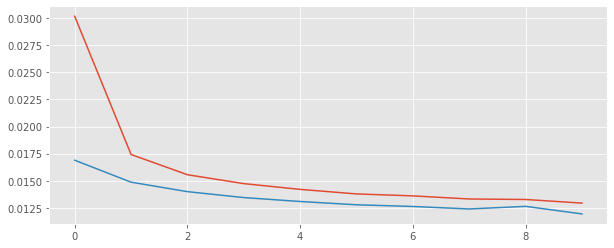

In [245]:
plt.figure(figsize = (10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [246]:
test_predictions = model.predict([x_test_s , x_test_n])

In [247]:
predicted_stocks = scaler_op.inverse_transform(test_predictions)
original_to_pred = scaler_op.inverse_transform(y_test)

In [248]:
from sklearn.metrics import mean_absolute_error

In [249]:
mse = mean_absolute_error(predicted_stocks, original_to_pred)

In [250]:
mse

5951.713306131561

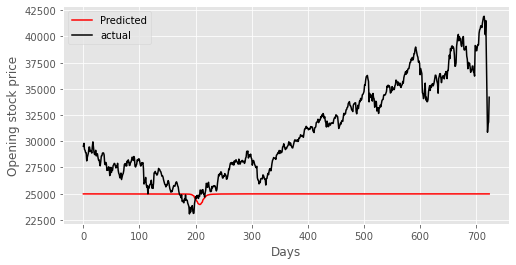

In [251]:
plt.style.use('ggplot')
plt.figure(figsize = (8,4))
plt.plot(predicted_stocks, color = 'red' , label = 'Predicted')
plt.plot(original_to_pred,color = 'black' , label = 'actual')
plt.xlabel('Days')
plt.ylabel('Opening stock price')
plt.legend()
plt.show()